<a href="https://colab.research.google.com/github/dssg/peeps-chili/blob/kit_score_granularity/testbed/bias_reduction_granularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploring Improving Fairness by Accounting for Score Uncertainty

In resource-constrained settings, we often see post-hoc score adjustments providing considerable gains in reducing disparities without loss in model accuracy. One potential way of interpreting this result is that the model scores offer a false sense of precision and the adjustments we're making really are simply choosing among individuals with scores that are truly equivalent in their predictive power. That is, although the post-hoc adjustment procedure may facially appear to be "traditional" affirmative action in the sense of using different thresholds for decisions about different types of individuals, in many cases it may actually be inaccurate to map these "different" score thresholds to any sort of real-world concept of qualification or need. The inherent uncertainty in the system simply doesn't justify sorting an individual with a score of, say, 0.8574 above one with a score of 0.8572 -- perhaps these should simply both be treated as a score of 0.86?

More generally, it is often the case that there are a large number of candidates that are qualified for a job or university admission, or a large number of individuals have needs that would be served by a program such that when there are only enough resources to interview or offer services to a subset of these applicants, there are many subsets of the overall pool which might be equivalent in terms of qualification/need but have different fairness characteristics.

This reasoning motivates the approach I'm exploring in this notebook -- if we acknowledge and account for the uncertainty in the model scores, then can choose more fair sets among individuals with these equivalent scores (particularly around the top k threshold)? In turn, would this sort of approach potentially be more tractable in settings where there is concern about using different thresholds for different individuals?

By way of poking at this problem, I'm starting with the same data used by our fairness tutorial for a proof-of-concept analysis.

## 1. Install dependencies, import packages and data
This is needed every time you open this notebook in **colab** to install dependencies

In [1]:
# packages not installed in colab
!pip install aequitas==0.42.0
!pip install fairlearn==0.4.6


import yaml
import os
import math
import pandas as pd
import numpy as np
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import fairlearn
import warnings
warnings.filterwarnings("ignore")
sns.set() 
DPI = 200
DATAPATH = 'https://github.com/dssg/fairness_tutorial/raw/master/data/'

     |████████████████████████████████| 2.2 MB 5.8 MB/s 
     |████████████████████████████████| 97 kB 5.0 MB/s 
     |████████████████████████████████| 727 kB 31.8 MB/s 
     |████████████████████████████████| 456 kB 38.2 MB/s 
     |████████████████████████████████| 596 kB 38.2 MB/s 
     |████████████████████████████████| 83 kB 810 kB/s 
     |████████████████████████████████| 161 kB 46.2 MB/s 
     |████████████████████████████████| 45 kB 2.8 MB/s 
     |████████████████████████████████| 62 kB 648 kB/s 
     |████████████████████████████████| 2.7 MB 37.8 MB/s 
  Created wheel for Flask-Bootstrap: filename=Flask_Bootstrap-3.3.7.1-py3-none-any.whl size=460123 sha256=2f24f2ffeda0f453e5f301d3b706772d88e83b16ac4827ff501ec35edad4d659
  Stored in directory: /root/.cache/pip/wheels/67/a2/d6/50d039c9b59b4caca6d7b53839c8100354a52ab7553d2456eb
  Created wheel for markdown2: filename=markdown2-2.3.5-py3-none-any.whl size=33327 sha256=075c6a11b504b8564e5640180f2589584203c42d715dc15438477e1ac260

## What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. 

As described earlier, the goal here is to select top 1000 project submissions that are likely to not get funded in order to prioritize resource allocation. That corresponds to the metric **Precision at top 1000**.

### <font color=red>We audited the "best" model at precision at top 1000 and found that it has disparities for True Positive Rate for all attributes that we care about (poverty_level of the school, sex, and school_location_type)</font>


## What do we want to do now?

1. Could we have picked a different model that was similar enough in "precision at top 1000" but less biased?


## Load predictions, labels, and attributes for all models that were built to audit

We have trained 400 models using random sampling of hyperparameters for the following algorithms: RandomForest, Logistic Regression, MLP and LightGBM. The `evals_df` contains a table with the performance metrics for each model on the holdout test set.

In [2]:
evals_df = pd.read_csv(DATAPATH +'split2_evals.csv.gz', compression='gzip')
# Let's sort the models by Precision at top 1000 predicted positives (our performance metric of interest for this case study)
evals_df.sort_values('model_precision', ascending = False)
evals_df.head(10)

,model_precision,model_classpath,hyperparameters,model_uuid,predictions_uuid,target_pp,matrix_type,matrix_start_date,matrix_end_date
0,0.552,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,test,2012-12-01,2013-01-31
1,0.551,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,test,2012-12-01,2013-01-31
2,0.550,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",8823d053f9fbe6c34efdae3a2f24c39c,5e78e49f70fac0193eaadb8513428f23,1000,test,2012-12-01,2013-01-31
3,0.549,lightgbm.LGBMClassifier,"{""n_jobs"": -1, ""max_depth"": 2, ""num_leaves"": 5...",ffc7abef4fe933b0f0cfed63d5d03910,f04edad1446642411085e84271898506,1000,test,2012-12-01,2013-01-31
4,0.548,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",110d892ce37127a79d7c6e0eac9a5d13,09092f371176a13cddca59bac20da4fd,1000,test,2012-12-01,2013-01-31
5,0.547,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""entropy"", ""max_de...",856a91cee8d3e81d35b0c7578d8459cb,dc9f61602f5c90b70aa8e6040eaf2972,1000,test,2012-12-01,2013-01-31
6,0.544,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",9d582bc500e1d99e0949ec9d35ae8eb3,d3de1db6eed5cfab17d64d6a13e20c8d,1000,test,2012-12-01,2013-01-31
7,0.544,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",bcc12af1a0ae151aabd5238e3a4fb242,eb671681600d5304fce6873004c61c50,1000,test,2012-12-01,2013-01-31
8,0.543,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""gini"", ""max_depth...",7fa15e633491add493d45e9dc7440315,5bd60c3f912e6d62b9acf7b3a56ae803,1000,test,2012-12-01,2013-01-31
9,0.543,sklearn.ensemble.RandomForestClassifier,"{""n_jobs"": -1, ""criterion"": ""entropy"", ""max_de...",da8d97ec5529f435974e238b1b29cf7f,4cd560dcb70bfe5bfef3ad1628eaba8a,1000,test,2012-12-01,2013-01-31


### Spot-check the model with highest precision at 1000 to see what type it is

In [3]:
print('Highest precision model classpath and hyperparameters: \n\n' , evals_df['model_classpath'][0], '\n', evals_df['hyperparameters'][0])

Highest precision model classpath and hyperparameters: 

 sklearn.ensemble.RandomForestClassifier 
 {"n_jobs": -1, "criterion": "gini", "max_depth": 30, "max_features": "sqrt", "n_estimators": 87, "random_state": 213500298, "min_samples_leaf": 44, "min_samples_split": 3}


## Load pre-computed Aequitas audit results 

The `aequitas_df` contains a table with the bias audit results for the 400 models for all the attributes we care about (we pre-selected the metrics of interest for this tutorial). 

In [4]:
aequitas_df = pd.read_csv(DATAPATH + 'split2_aequitas.csv.gz', compression='gzip')
aequitas_df.head(10)

,model_uuid,predictions_uuid,k,attribute_name,attribute_value,tpr,tpr_disparity,tpr_ref_group_value,pp,tp,group_label_pos,prev,group_size,matrix_type,matrix_start_date,matrix_end_date
0,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,suburban_rural,0.139156,1.000000,suburban_rural,626,333,2393,0.367814,6506,test,2012-12-01,2013-01-31
1,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,metro_type,urban,0.042674,0.306665,suburban_rural,192,120,2812,0.308502,9115,test,2012-12-01,2013-01-31
2,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,teacher_sex,female,0.102390,3.370670,male,951,527,5147,0.341019,15093,test,2012-12-01,2013-01-31
3,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,poverty_level,lower,0.137859,1.000000,lower,753,394,2858,0.370976,7704,test,2012-12-01,2013-01-31
4,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,poverty_level,highest,0.050771,0.368285,lower,247,158,3112,0.312043,9973,test,2012-12-01,2013-01-31
5,a04e2eedd9c5ff18bcf77e84ae9db561,c598fbe93f4c218ac7d325fb478598f1,1000,teacher_sex,male,0.030377,1.000000,male,49,25,823,0.318498,2584,test,2012-12-01,2013-01-31
6,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,poverty_level,lower,0.149405,1.000000,lower,805,427,2858,0.370976,7704,test,2012-12-01,2013-01-31
7,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,poverty_level,highest,0.039846,0.266696,lower,195,124,3112,0.312043,9973,test,2012-12-01,2013-01-31
8,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,teacher_sex,female,0.101613,2.986684,male,944,523,5147,0.341019,15093,test,2012-12-01,2013-01-31
9,3f8f65db414b74ba1c4773e131bdb51d,2d8e4d82f4e67e1de1de8650a7838fc2,1000,teacher_sex,male,0.034022,1.000000,male,56,28,823,0.318498,2584,test,2012-12-01,2013-01-31


Combining the `evals_df` with the `aequitas_df` allow us to get a clearer picture how the different models compare with each other in both performance and bias of our groups of interest. 

The `create_scatter_disparity_performance` method will help us to easily plot the 400 models bias-performance tradeoffs and it's going to be used throughout the notebook.

In [5]:
def create_scatter_disparity_performance(evals_df, aequitas_df,  attr_col, group_name, 
                                         performance_col='model_precision', bias_metric='tpr', flip_disparity=False, 
                                         mitigated_tags=[], mitigated_bdfs=[], mitigated_performances=[], ylim=None):
    disparity_df = aequitas_df.loc[(aequitas_df['attribute_name']==attr_col) & (aequitas_df['attribute_value']==group_name)].copy()
    disparity_metric = bias_metric + '_disparity'
    scatter_schema = ['model_uuid', performance_col, 'attribute_name', 'attribute_value', bias_metric, disparity_metric, 'model_tag']
    if flip_disparity:
        disparity_df[disparity_metric]= disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)
    scatter = pd.merge(evals_df, disparity_df, how='left', on=['model_uuid'], sort=True, copy=True)
    scatter = scatter[['model_uuid', performance_col, 'attribute_name', 'attribute_value', bias_metric, disparity_metric]].copy()
    scatter['model_tag'] = 'Other Models'
    scatter.sort_values('model_precision', ascending = False, inplace=True, ignore_index=True)
    scatter['model_tag'] = scatter.apply(lambda x: 'Highest Precision at 1000' if int(x.name) < 1 else x['model_tag'], axis=1)
    mitigated_points = []
    scatter_final = pd.DataFrame()
    if mitigated_bdfs and mitigated_performances:
        for i in range(len(mitigated_bdfs)):
            if not mitigated_bdfs[i].empty and mitigated_performances[i] !=None:
                mitigated_bdfs[i][performance_col] = mitigated_performances[i]
                mitigated_bdfs[i]['model_tag'] = mitigated_tags[i]
                new_disparity_df = mitigated_bdfs[i].loc[(mitigated_bdfs[i]['attribute_name']==attr_col) & (mitigated_bdfs[i]['attribute_value']==group_name)].copy()
                if flip_disparity:
                    new_disparity_df[disparity_metric]= new_disparity_df.apply(lambda x: 1/x[disparity_metric] , axis=1)
                scatter_new = new_disparity_df[[c for c in new_disparity_df.columns if c in scatter_schema]].copy()
                mitigated_points.append(scatter_new)
        scatter_final = pd.concat(mitigated_points , axis=0)

    ax = sns.scatterplot(
        x='model_precision', y=disparity_metric, hue='model_tag',
        data=scatter,
        alpha=0.4, s=20, palette = np.array(sns.color_palette()[0:2])


    )
    if not scatter_final.empty:
        ax1 = sns.scatterplot(
            x='model_precision', y=disparity_metric, hue='model_tag',
            data=scatter_final,
            alpha = 0.95, s=20,  palette = np.array(sns.color_palette()[2:3] + sns.color_palette()[4:])
        )

    if ylim:
        plt.ylim(0, 10)
    flip_placeholder = 'Flipped' if flip_disparity else ''
    ax.set_title('{} {} vs.{} for {}:{}'.format(flip_placeholder, disparity_metric, performance_col, attr_col,group_name ), y=1., fontsize='xx-small')
    #plt.gcf().set_size_inches((4, 3))
    plt.legend(loc='upper left', fontsize='xx-small', prop={'size': 5})
    plt.gcf().set_dpi(DPI)
    plt.show() 




## Let's see if we could have picked a better model for fairness in Poverty Level

Each point in the scatterplot represents a model. We highlight the model we picked before (highest global performance).

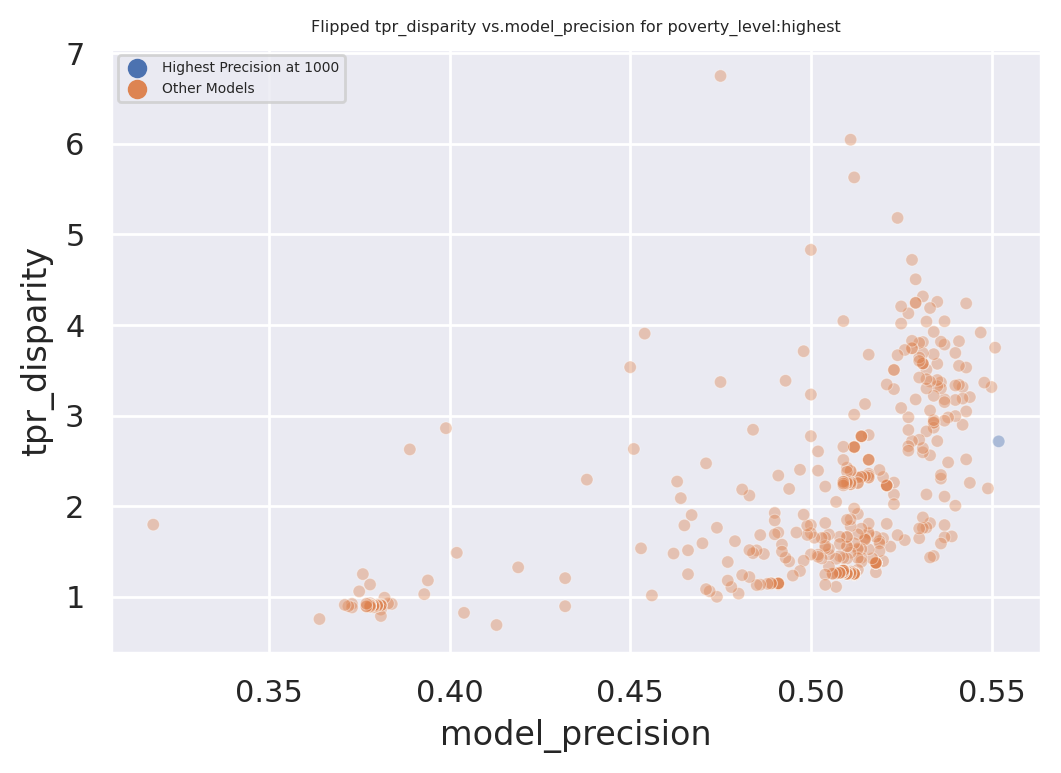

In [6]:
create_scatter_disparity_performance(evals_df, aequitas_df, 'poverty_level', 'highest', flip_disparity=True )

## Let's see if we could have picked a better model for fairness in Metro Type


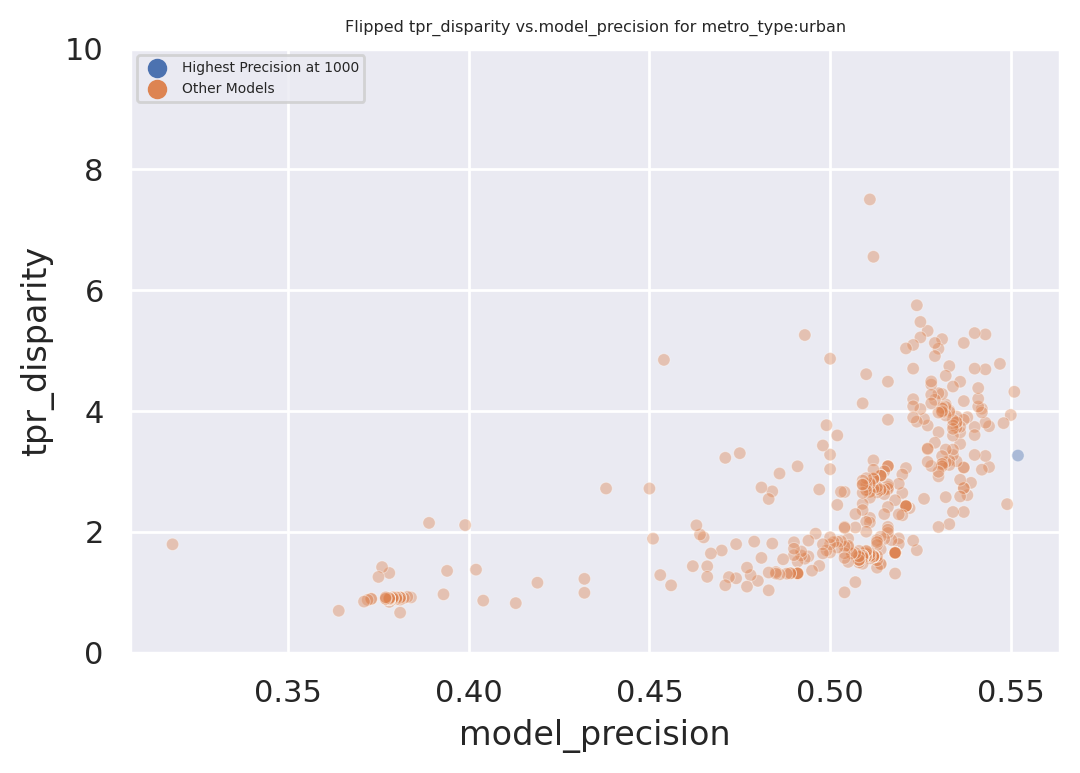

In [7]:
create_scatter_disparity_performance(evals_df, aequitas_df, 'metro_type', 'urban', flip_disparity=True, ylim=10 )

## Let's see if we could have picked a better model for fairness in Teacher sex



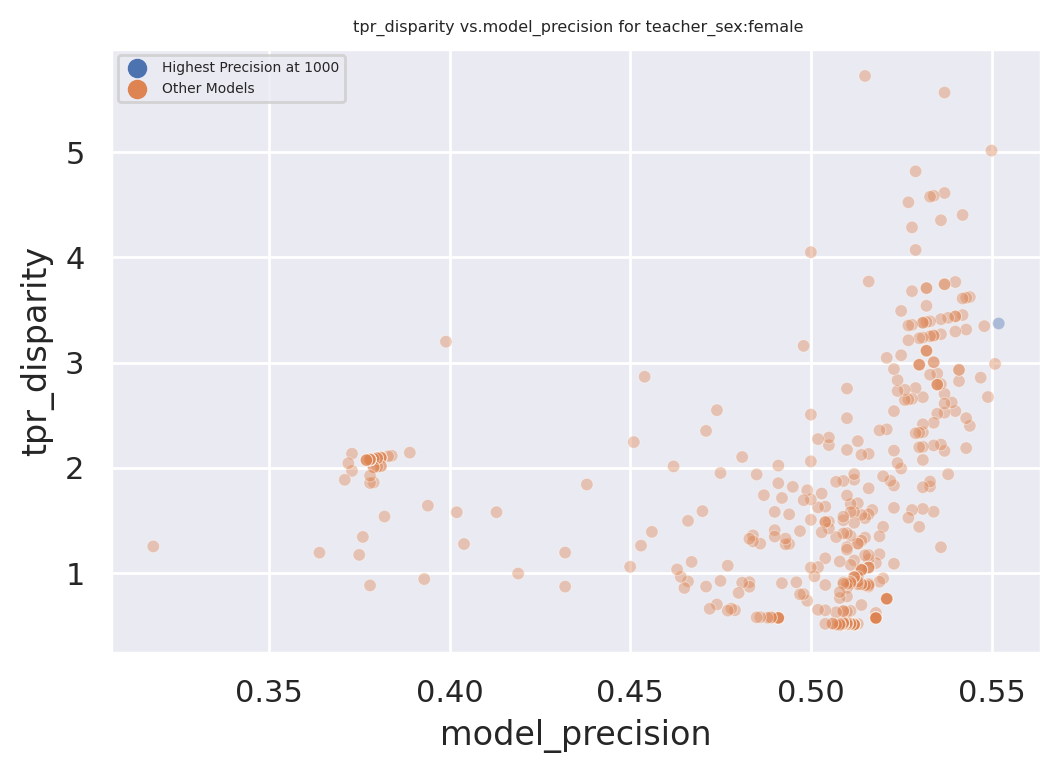

In [8]:
create_scatter_disparity_performance(evals_df, aequitas_df, 'teacher_sex', 'female', flip_disparity=False )

## <font color=red>Bias Reduction Strategy 3: Post-Hoc Disparity Mitigation</font>

### What has already happened?

We've already cleaned data, generated features, created train-test sets, built 1000s of models on each training set and scored each test set with them, and calculated various evaluation metrics. We then used these results to pick a "best" model in terms of performance on the "accuracy" metric we care about: **Precision at the top 1000** (corresponding to our goal of selecting 1000 project submissions that are most likely to not get funded in order to prioritize resource allocation).

When we audited this selected model with Aequitas, however, we found biases across many attributes, including the poverty level of the schools. Here, we explore a method of using post-hoc disparity mitigation to reduce this bias in the selected model.

### <font color=green>Intro to Post-Hoc Bias Mitigation</font>

![Diagram of Post-Hoc Adjustments](post_hoc_adj.png "Post-Hoc Adjustments")

One approach to improving the fairness of our model is to make post-hoc adjustments to the thresholds used for each subgroup to choose the 1,000 projects on which to intervene. Because our fairness metric here (**recall** aka **tpr** aka **equality of opportunity**) is monatonically increasing with the depth of the score, we should be able to find score thresholds for each subgroup that will equalize this metric across the groups, subject to the constraint that we want to choose a total of 1,000 projects for our intervation.

In short, here's how this will work (see the references below for a more detailed discussion):
1. Train the model as usual on a training set, predict scores on a test set
2. Split this test set by subgroups on our protected attribute (here, poverty level)
3. Sort each subgroup by score and calculate the cumulative tpr/recall up to and including each row in the set, storing this "rolling within-subgroup recall" value
4. Recombine the subgroups, and sort the entire set by this new value
5. Take the top 1,000 projects from this re-ordered list and use it to calculate "top k" sizes for each subgroup that equalize recall
6. Then, on a future test set, use these calculated subgroup list sizes to assess the impact of disparities and overall precision

References:
- Hardt, et al, [Equality of Opportunity in Supervised Learning](http://papers.nips.cc/paper/6373-equality-of-opportunity-in-supervised-learning)
- Rodolfa, et al, [Case Study: Predictive Fairness to Reduce Misdemeanor Recidivism Through Social Service Interventions](https://dl.acm.org/doi/abs/10.1145/3351095.3372863?casa_token=zc196JJrqkkAAAAA:bPmqmKrA91esJhIxHPT4K1crWWb5JGcflVFDkTgODctMzLpUX50_56Kyyh4NJ2GTd_QSydqhNpjT)

### Load the train, test, and protected attributes from the first split

In [9]:
split1_traindf = pd.read_csv(DATAPATH + 'train_20111101_20120201.csv.gz', compression='gzip')
split1_testdf = pd.read_csv(DATAPATH + 'test_20120601_20120801.csv.gz', compression='gzip')
split1_attrdf = pd.read_csv(DATAPATH + 'test_20120601_20120801_protected.csv.gz', compression='gzip')

Let's just take a quick look at the data to make sure it makes sense:

In [10]:
split1_traindf.head()

,entity_id,as_of_date,project_features_entity_id_all_grade_level_Grades35_sum,project_features_entity_id_all_grade_level_Grades68_sum,project_features_entity_id_all_grade_level_Grades912_sum,project_features_entity_id_all_grade_level_GradesPreK2_sum,project_features_entity_id_all_grade_level__NULL_sum,project_features_entity_id_all_resource_type_Books_sum,project_features_entity_id_all_resource_type_Other_sum,project_features_entity_id_all_resource_type_Supplies_sum,...,donation_features_entity_id_all_zip_avg_donations_2yr_imp,donation_features_entity_id_all_zip_funding_rate_1yr_sum,donation_features_entity_id_all_zip_funding_rate_1yr_imp,donation_features_entity_id_all_zip_funding_rate_2yr_sum,donation_features_entity_id_all_zip_funding_rate_2yr_imp,quickstart_label,project_features_entity_id_all_poverty_level_highpoverty,project_features_entity_id_all_poverty_level_highestpoverty,project_features_entity_id_all_poverty_level_lowpoverty,project_features_entity_id_all_poverty_level_moderatepoverty
0,313448,1320105600000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.636364,0.0,0.696970,0.0,1.0,1.0,0.0,0.0,0.0
1,313441,1320105600000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.000000,1.0,0.000000,1.0,0.0,0.0,0.0,1.0,0.0
2,313449,1320105600000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.300000,0.0,0.592593,0.0,1.0,1.0,0.0,0.0,0.0
3,313447,1320105600000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.000000,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,1.0
4,313446,1320105600000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.111111,0.0,0.652174,0.0,0.0,0.0,0.0,0.0,1.0


### Set up some parameters we'll need below

Note that the classifier type and hyperparameters here are from the best-performing model we chose above based on precision on the top 1000.

In [11]:
hyperparameters = {
    'criterion': 'gini',
    'max_depth': 30,
    'max_features': 'sqrt',
    'min_samples_leaf': 44,
    'min_samples_split': 3,
    'n_estimators': 87,
    'n_jobs': -1,
    'random_state': 213500298
}
clf = RandomForestClassifier(**hyperparameters)

top_k = 1000

label_col = 'quickstart_label'
entity_col = 'entity_id'
date_col = 'as_of_date'
exclude_cols = [label_col, entity_col, date_col] # columns to exclude from the X matrices for the classifier

protected_attribute_col = 'poverty_level'

# Parameters for Aequitas

metrics = ['tpr']
disparity_threshold = 1.3
protected_attribute_ref_group = {protected_attribute_col:'lower'}


### Train the model and predict on the test set

In [12]:
# train
y_train = split1_traindf[label_col].values
clf.fit(split1_traindf.drop(exclude_cols, axis = 1), y_train)

# test set predictions
split1_preds = split1_testdf[[entity_col, date_col, label_col]].copy()
split1_preds['predict_proba'] = clf.predict_proba(split1_testdf.drop(exclude_cols, axis = 1))[:,1]

Let's take a quick look at the predictions to make sure they look good:

In [13]:
split1_preds.head()

,entity_id,as_of_date,quickstart_label,predict_proba
0,246363,1338591600000,1.0,0.382485
1,246362,1338591600000,1.0,0.188013
2,246361,1338591600000,0.0,0.398983
3,246360,1338591600000,0.0,0.422042
4,246359,1338591600000,1.0,0.403111


In [14]:
def round_to_nearest(score, grain=0.01):
  return round(score/grain)*grain

In [15]:
round_to_nearest(split1_preds['predict_proba'].head(), 0.01)

0    0.38
1    0.19
2    0.40
3    0.42
4    0.40
Name: predict_proba, dtype: float64

In [16]:
np.random.random(split1_preds.head().shape[0])

array([0.22850379, 0.73712738, 0.16153991, 0.7712197 , 0.68752984])

In [14]:
tmp_df = split1_preds.copy()
tmp_df['rounded_score'] = round_to_nearest(tmp_df['predict_proba'], 0.01)
tmp_df['tmp_random'] = np.random.random(tmp_df.shape[0])
tmp_df.sort_values(['rounded_score', 'tmp_random'], ascending=[False, False], inplace=True)
score_thresh = tmp_df.head(1000)['rounded_score'].min()
tmp_df.loc[tmp_df['rounded_score'] >= score_thresh].shape
tmp_df.head(1000)['quickstart_label'].mean()

0.616

In [15]:
tmp_df['tmp_random'] = np.random.random(tmp_df.shape[0])
tmp_df.sort_values(['rounded_score', 'tmp_random'], ascending=[False, False], inplace=True)
score_thresh = tmp_df.head(1000)['rounded_score'].min()
tmp_df.loc[tmp_df['rounded_score'] >= score_thresh].shape
tmp_df.head(1000)['quickstart_label'].mean()


0.615

In [16]:
# NOTE: assumes all examples have labels
def prec_at_k_trials(
    df, k, grain=None, n_trial=30,
    score_col='predict_proba', label_col='quickstart_label',
    rounded_col='rounded_score', rand_col='tmp_random'
):
  tmp_df = df.copy()
  if grain is not None:
    tmp_df[rounded_col] = round_to_nearest(tmp_df[score_col], grain)
  else:
    tmp_df[rounded_col] = tmp_df[score_col]
    grain = 0.0

  results = {
      'k': [],
      'grain': [],
      'score_thresh': [],
      'num_above_thresh': [],
      'prec_at_k': []
  }

  for t in range(n_trial):
    results['k'].append(k)
    results['grain'].append(grain)
    tmp_df[rand_col] = np.random.random(tmp_df.shape[0])
    tmp_df.sort_values([rounded_col, rand_col], ascending=[False, False], inplace=True)
    score_thresh = tmp_df.head(k)[rounded_col].min()
    results['score_thresh'].append(score_thresh)
    results['num_above_thresh'].append(tmp_df.loc[tmp_df[rounded_col] >= score_thresh].shape[0])
    results['prec_at_k'].append(tmp_df.head(k)[label_col].mean())

  del(tmp_df)
  return pd.DataFrame(results)

In [65]:
res_list = []
for grain in [None, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]:
  res_list.append(prec_at_k_trials(split1_preds, k=1000, grain=grain, n_trial=30))

results = pd.concat(res_list)

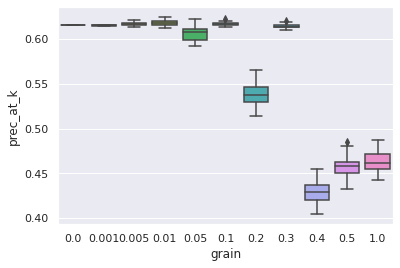

In [66]:
sns.boxplot('grain', 'prec_at_k', data=results)

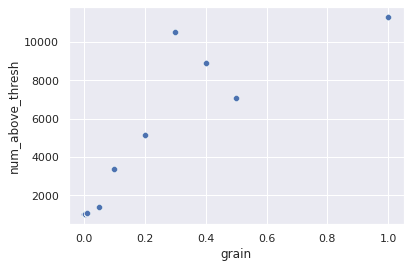

In [68]:
sns.scatterplot('grain', 'num_above_thresh', data=results)

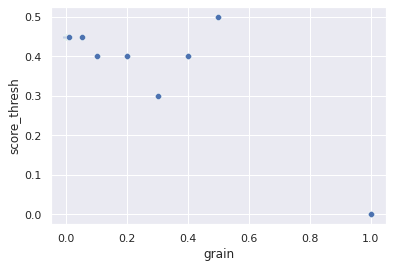

In [69]:
sns.scatterplot('grain', 'score_thresh', data=results)

In [22]:
pd.merge(split1_preds, split1_attrdf, how='left', on=[entity_col,date_col], sort=True, copy=True).groupby('poverty_level')['quickstart_label'].sum()

poverty_level
highest    2279.0
lower      2096.0
Name: quickstart_label, dtype: float64

In [23]:
pd.merge(split1_preds, split1_attrdf, how='left', on=[entity_col,date_col], sort=True, copy=True).shape

(11307, 7)

In [24]:
split1_preds.shape

(11307, 4)

In [19]:
# NOTE: assumes all examples have labels, only 2 attribute levels for bias
def prec_at_k_trials_bias(
    df, k, grain=None, n_trial=30,
    score_col='predict_proba', label_col='quickstart_label',
    rounded_col='rounded_score', rand_col='tmp_random',
    bias_attr='poverty_level', bias_denom='highest'
):
  tmp_df = df.copy()
  if grain is not None:
    tmp_df[rounded_col] = round_to_nearest(tmp_df[score_col], grain)
  else:
    tmp_df[rounded_col] = tmp_df[score_col]
    grain = 0.0

  results = {
      'k': [],
      'grain': [],
      'bias_attr': [],
      'bias_denom': [],
      'score_thresh': [],
      'num_above_thresh': [],
      'prec_at_k': [],
      'recall_disp': []
  }

  bias_denom_pos = tmp_df.loc[tmp_df[bias_attr] == bias_denom][label_col].sum()
  bias_num_pos = tmp_df.loc[tmp_df[bias_attr] != bias_denom][label_col].sum()

  for t in range(n_trial):
    results['k'].append(k)
    results['grain'].append(grain)
    tmp_df[rand_col] = np.random.random(tmp_df.shape[0])
    tmp_df.sort_values([rounded_col, rand_col], ascending=[False, False], inplace=True)

    tmp_df_topk = tmp_df.head(k).copy()

    score_thresh = tmp_df_topk[rounded_col].min()
    results['score_thresh'].append(score_thresh)
    results['num_above_thresh'].append(tmp_df.loc[tmp_df[rounded_col] >= score_thresh].shape[0])
    results['prec_at_k'].append(tmp_df_topk[label_col].mean())

    results['bias_attr'].append(bias_attr)
    results['bias_denom'].append(bias_denom)
    recall_denom = tmp_df_topk.loc[tmp_df_topk[bias_attr] == bias_denom][label_col].sum() / bias_denom_pos
    recall_num = tmp_df_topk.loc[tmp_df_topk[bias_attr] != bias_denom][label_col].sum() / bias_num_pos
    results['recall_disp'].append(recall_num / recall_denom)

    print(bias_denom_pos)
    print(recall_denom)
    print(bias_num_pos)
    print(recall_num)

    del(tmp_df_topk)

  del(tmp_df)
  return pd.DataFrame(results)

In [17]:
split1_combined = pd.merge(split1_preds, split1_attrdf, how='left', on=[entity_col,date_col], sort=True, copy=True)

In [20]:
prec_at_k_trials_bias(split1_combined, k=1000, grain=1.0, n_trial=1)

2279.0
0.0877577885037297
2096.0
0.12881679389312978


,k,grain,bias_attr,bias_denom,score_thresh,num_above_thresh,prec_at_k,recall_disp
0,1000,1.0,poverty_level,highest,0.0,11307,0.47,1.467867


In [20]:
split1_combined.groupby('poverty_level')['quickstart_label'].sum()

poverty_level
highest    2279.0
lower      2096.0
Name: quickstart_label, dtype: float64

In [21]:
tmp_df = split1_combined.copy()
tmp_df['rounded_score'] = round_to_nearest(tmp_df['predict_proba'], 0.1)
tmp_df['tmp_random'] = np.random.random(tmp_df.shape[0])
tmp_df.sort_values(['rounded_score', 'tmp_random'], ascending=[False, False], inplace=True)
score_thresh = tmp_df.head(1000)['rounded_score'].min()
tmp_df.loc[tmp_df['rounded_score'] >= score_thresh].shape
tmp_df.head(1000)['quickstart_label'].mean()

0.62

In [22]:
tmp_df.head(1000).groupby('poverty_level')['quickstart_label'].sum()

poverty_level
highest    221.0
lower      399.0
Name: quickstart_label, dtype: float64

In [23]:
split1_combined.groupby('poverty_level')['entity_id'].count()

poverty_level
highest    6606
lower      4701
Name: entity_id, dtype: int64

In [42]:
tmp_df.head(1000).groupby('poverty_level')['entity_id'].count()

poverty_level
highest    581
lower      419
Name: entity_id, dtype: int64

In [43]:
(581/6606, 419/4701)

(0.08795034816833182, 0.0891299723463093)

In [44]:
tmp_df.groupby('rounded_score')['entity_id'].count()

rounded_score
0.0    11307
Name: entity_id, dtype: int64

In [26]:
tmp_df = split1_combined.copy()
tmp_df['rounded_score'] = round_to_nearest(tmp_df['predict_proba'], 0.01)
tmp_df['tmp_random'] = np.random.random(tmp_df.shape[0])
tmp_df.sort_values(['rounded_score', 'tmp_random'], ascending=[False, False], inplace=True)
score_thresh = tmp_df.head(1000)['rounded_score'].min()
tmp_df.loc[tmp_df['rounded_score'] >= score_thresh].shape
tmp_df.head(1000)['quickstart_label'].mean()

0.618

In [27]:
score_thresh

0.45

In [28]:
tmp_df.loc[tmp_df['rounded_score'] > score_thresh].shape

(903, 9)

In [30]:
needed = 1000 - tmp_df.loc[tmp_df['rounded_score'] > score_thresh].shape[0]
tmp_df.loc[tmp_df['rounded_score'] == score_thresh].groupby('poverty_level')['entity_id'].count()

poverty_level
highest    69
lower      97
Name: entity_id, dtype: int64

In [35]:
wanted_denom = round(needed*0.3)
wanted_num = needed - wanted_denom

avail_denom = tmp_df.loc[(tmp_df['rounded_score'] == score_thresh) & (tmp_df['poverty_level'] == 'highest')].shape[0]
avail_num = tmp_df.loc[(tmp_df['rounded_score'] == score_thresh) & (tmp_df['poverty_level'] != 'highest')].shape[0]

if avail_denom < wanted_denom:
  wanted_denom = avail_denom
  wanted_num = needed - wanted_denom
elif avail_num < wanted_num:
  wanted_num = avail_num
  wanted_denom = needed - wanted_num

tmp_df['tmp_random'] = np.random.random(tmp_df.shape[0])
tmp_df.sort_values(['rounded_score', 'tmp_random'], ascending=[False, False], inplace=True)

tmp_df_selected = pd.concat([
    tmp_df.loc[tmp_df['rounded_score'] > score_thresh],
    tmp_df.loc[(tmp_df['rounded_score'] == score_thresh) & (tmp_df['poverty_level'] == 'highest')].head(wanted_denom),
    tmp_df.loc[(tmp_df['rounded_score'] == score_thresh) & (tmp_df['poverty_level'] != 'highest')].head(wanted_num)
])

In [36]:
tmp_df_selected.shape

(1000, 9)

In [38]:
tmp_df_selected['quickstart_label'].mean()

0.618

In [39]:
tmp_df_selected.groupby('poverty_level')['quickstart_label'].sum()

poverty_level
highest    212.0
lower      406.0
Name: quickstart_label, dtype: float64

In [75]:
# NOTE: assumes all examples have labels, only 2 attribute levels for bias
def prec_at_k_trials_bias(
    df, k, grain=None, n_trial=5,
    score_col='predict_proba', label_col='quickstart_label',
    rounded_col='rounded_score', rand_col='tmp_random',
    bias_attr='poverty_level', bias_denom='highest'
):
  tmp_df = df.copy()
  if grain is not None:
    tmp_df[rounded_col] = round_to_nearest(tmp_df[score_col], grain)
  else:
    tmp_df[rounded_col] = tmp_df[score_col]
    grain = 0.0

  results = {
      'k': [],
      'grain': [],
      'bias_attr': [],
      'bias_denom': [],
      'ties_denom_frac': [],
      'score_thresh': [],
      'num_above_thresh': [],
      'num_selected': [],
      'needed_at_thresh': [],
      'prec_at_k': [],
      'recall_disp': []
  }

  bias_denom_pos = tmp_df.loc[tmp_df[bias_attr] == bias_denom][label_col].sum()
  bias_num_pos = tmp_df.loc[tmp_df[bias_attr] != bias_denom][label_col].sum()

  tmp_df[rand_col] = np.random.random(tmp_df.shape[0])
  tmp_df.sort_values([rounded_col, rand_col], ascending=[False, False], inplace=True)
  score_thresh = tmp_df.head(k)[rounded_col].min()
  needed = k - tmp_df.loc[tmp_df[rounded_col] > score_thresh].shape[0]

  for frac in np.arange(0, 1.1, 0.1):

    wanted_denom = round(needed*frac)
    wanted_num = needed - wanted_denom

    avail_denom = tmp_df.loc[(tmp_df[rounded_col] == score_thresh) & (tmp_df[bias_attr] == bias_denom)].shape[0]
    avail_num = tmp_df.loc[(tmp_df[rounded_col] == score_thresh) & (tmp_df[bias_attr] != bias_denom)].shape[0]

    if avail_denom < wanted_denom:
      wanted_denom = avail_denom
      wanted_num = needed - wanted_denom
    elif avail_num < wanted_num:
      wanted_num = avail_num
      wanted_denom = needed - wanted_num

    for t in range(n_trial):

      tmp_df[rand_col] = np.random.random(tmp_df.shape[0])
      tmp_df.sort_values([rounded_col, rand_col], ascending=[False, False], inplace=True)

      tmp_df_selected = pd.concat([
          tmp_df.loc[tmp_df[rounded_col] > score_thresh],
          tmp_df.loc[(tmp_df[rounded_col] == score_thresh) & (tmp_df[bias_attr] == bias_denom)].head(wanted_denom),
          tmp_df.loc[(tmp_df[rounded_col] == score_thresh) & (tmp_df[bias_attr] != bias_denom)].head(wanted_num)
      ])


      results['k'].append(k)
      results['grain'].append(grain)
      results['score_thresh'].append(score_thresh)
      results['num_above_thresh'].append(tmp_df.loc[tmp_df[rounded_col] >= score_thresh].shape[0])
      results['num_selected'].append(tmp_df_selected.shape[0])
      results['needed_at_thresh'].append(needed)
      results['prec_at_k'].append(tmp_df_selected[label_col].mean())

      results['bias_attr'].append(bias_attr)
      results['bias_denom'].append(bias_denom)
      results['ties_denom_frac'].append(frac)
      recall_denom = tmp_df_selected.loc[tmp_df_selected[bias_attr] == bias_denom][label_col].sum() / bias_denom_pos
      recall_num = tmp_df_selected.loc[tmp_df_selected[bias_attr] != bias_denom][label_col].sum() / bias_num_pos
      results['recall_disp'].append(recall_num / recall_denom)

      del(tmp_df_selected)

  del(tmp_df)
  return pd.DataFrame(results)

In [98]:
res_df = prec_at_k_trials_bias(split1_combined, k=1000, grain=0.04, n_trial=5)

In [99]:
res_df.head(10)

,k,grain,bias_attr,bias_denom,ties_denom_frac,score_thresh,num_above_thresh,num_selected,needed_at_thresh,prec_at_k,recall_disp
0,1000,0.04,poverty_level,highest,0.0,0.44,1486,1000,174,0.623,2.634634
1,1000,0.04,poverty_level,highest,0.0,0.44,1486,1000,174,0.623,2.634634
2,1000,0.04,poverty_level,highest,0.0,0.44,1486,1000,174,0.625,2.646582
3,1000,0.04,poverty_level,highest,0.0,0.44,1486,1000,174,0.617,2.598788
4,1000,0.04,poverty_level,highest,0.0,0.44,1486,1000,174,0.625,2.646582
5,1000,0.04,poverty_level,highest,0.1,0.44,1486,1000,174,0.626,2.439403
6,1000,0.04,poverty_level,highest,0.1,0.44,1486,1000,174,0.631,2.523702
7,1000,0.04,poverty_level,highest,0.1,0.44,1486,1000,174,0.621,2.504281
8,1000,0.04,poverty_level,highest,0.1,0.44,1486,1000,174,0.627,2.500811
9,1000,0.04,poverty_level,highest,0.1,0.44,1486,1000,174,0.627,2.500811


(0.0, 3.0)

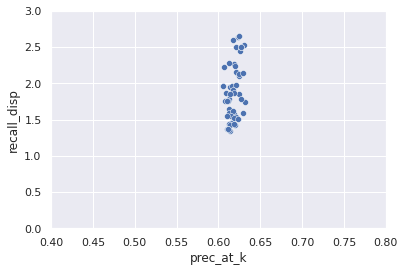

In [100]:
ax = sns.scatterplot('prec_at_k', 'recall_disp', data=res_df)
ax.set_xlim((0.4,0.8))
ax.set_ylim((0,3))

In [101]:
# 554 highest, 446 lower
tmp_df = split1_combined.copy()
tmp_df['tmp_random'] = np.random.random(tmp_df.shape[0])
tmp_df.sort_values(['predict_proba', 'tmp_random'], ascending=[False, False], inplace=True)

tmp_df_selected = pd.concat([
    tmp_df.loc[tmp_df['poverty_level'] == 'highest'].head(554),
    tmp_df.loc[tmp_df['poverty_level'] != 'highest'].head(446)
])

In [103]:
tmp_df_selected['quickstart_label'].mean()

0.603

In [104]:
tmp_df.groupby('poverty_level')['quickstart_label'].sum()

poverty_level
highest    2279.0
lower      2096.0
Name: quickstart_label, dtype: float64

In [105]:
tmp_df_selected.groupby('poverty_level')['quickstart_label'].sum()

poverty_level
highest    314.0
lower      289.0
Name: quickstart_label, dtype: float64

In [106]:
(289/2096) / (314/2297)

1.008644004959401

In [107]:
tmp_df.head(1000)['quickstart_label'].mean()

0.616

What seems to be messy here is that decreasing granularity may be related with a larger number of ties at the top k threshold score (though not necessarily monotonically given the score distribution), but is generally clearly related to the number of these tied examples that are needed to round out the top k -- decreasing the granularity can sometimes mean we only need a handful of these examples (so don't have much room to make adjustments even though we have a large number of ties) or could mean we need a large number of them (and therefore more able to find a solution that improves fairness).

Perhaps a cleaner way to account for this concept of granularity is to focus on the score at the top k threshold, since that's the only one that matters in practice and we effectively care about ties above and below it...

In [124]:
rand_col = 'tmp_random'
score_col = 'predict_proba'
label_col = 'quickstart_label'
k = 1000
grain = 0.0

tmp_df = split1_combined.copy()
tmp_df[rand_col] = np.random.random(tmp_df.shape[0])
tmp_df.sort_values([score_col, rand_col], ascending=[False, False], inplace=True)

score_thresh = tmp_df.head(k)[score_col].min()

score_high = score_thresh + grain
score_low = score_thresh - grain

tmp_df['tmp_selection'] = 0.0
tmp_df.loc[tmp_df[score_col] > score_high, 'tmp_selection'] = 1.0
tmp_df.loc[(tmp_df[score_col] <= score_high) & (tmp_df[score_col] >= score_low), 'tmp_selection'] = 0.5

tmp_df.sort_values(['tmp_selection', rand_col], ascending=[False, False], inplace=True)

tmp_df.head(k)[label_col].mean()


0.616

In [21]:
# NOTE: assumes all examples have labels
def prec_at_k_trials_v2(
    df, k, grain=0.0, n_trial=30,
    score_col='predict_proba', label_col='quickstart_label',
    seln_col='tmp_selection', rand_col='tmp_random'
):
  results = {
      'k': [],
      'grain': [],
      'score_thresh': [],
      'num_above_high': [],
      'num_at_thresh': [],
      'prec_at_k': []
  }

  tmp_df = df.copy()
  tmp_df[rand_col] = np.random.random(tmp_df.shape[0])
  tmp_df.sort_values([score_col, rand_col], ascending=[False, False], inplace=True)

  score_thresh = tmp_df.head(k)[score_col].min()

  score_high = score_thresh + grain
  score_low = score_thresh - grain

  tmp_df[seln_col] = 0.0
  tmp_df.loc[tmp_df[score_col] > score_high, seln_col] = 1.0
  tmp_df.loc[(tmp_df[score_col] <= score_high) & (tmp_df[score_col] >= score_low), seln_col] = 0.5


  for t in range(n_trial):
    tmp_df[rand_col] = np.random.random(tmp_df.shape[0])
    tmp_df.sort_values([seln_col, rand_col], ascending=[False, False], inplace=True)

    results['k'].append(k)
    results['grain'].append(grain)
    results['score_thresh'].append(score_thresh)
    results['num_above_high'].append(tmp_df.loc[tmp_df[seln_col] == 1.0].shape[0])
    results['num_at_thresh'].append(tmp_df.loc[tmp_df[seln_col] == 0.5].shape[0])
    results['prec_at_k'].append(tmp_df.head(k)[label_col].mean())

  del(tmp_df)
  return pd.DataFrame(results)

In [22]:
res_list = []
for grain in [0.000, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0]:
  res_list.append(prec_at_k_trials_v2(split1_preds, k=1000, grain=grain, n_trial=30))

results = pd.concat(res_list)

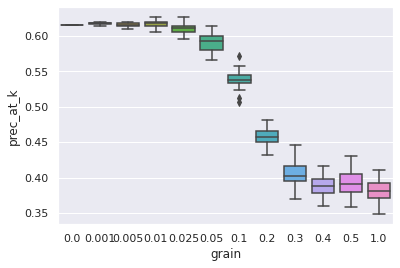

In [23]:
sns.boxplot('grain', 'prec_at_k', data=results)

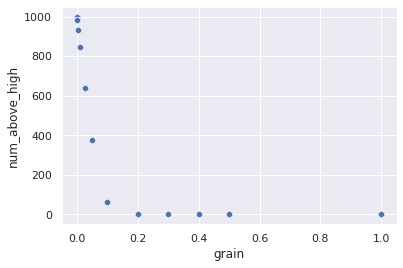

In [24]:
sns.scatterplot('grain', 'num_above_high', data=results)

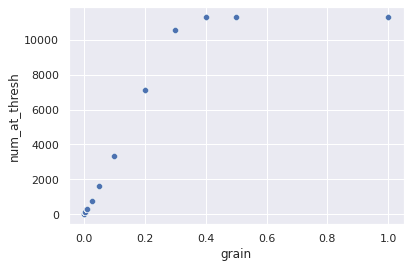

In [25]:
sns.scatterplot('grain', 'num_at_thresh', data=results)

In [26]:
# NOTE: assumes all examples have labels,  only 2 attribute levels for bias
def prec_at_k_trials_bias_v2(
    df, k, grain=0.0, n_trial=5,
    score_col='predict_proba', label_col='quickstart_label',
    seln_col='tmp_selection', rand_col='tmp_random',
    bias_attr='poverty_level', bias_denom='highest'
):
  results = {
      'k': [],
      'grain': [],
      'bias_attr': [],
      'bias_denom': [],
      'ties_denom_frac': [],
      'score_thresh': [],
      'num_above_high': [],
      'num_selected': [],
      'needed_at_thresh': [],
      'num_at_thresh': [],
      'prec_at_k': [],
      'recall_disp': []
  }

  tmp_df = df.copy()
  tmp_df[rand_col] = np.random.random(tmp_df.shape[0])
  tmp_df.sort_values([score_col, rand_col], ascending=[False, False], inplace=True)

  score_thresh = tmp_df.head(k)[score_col].min()

  score_high = score_thresh + grain
  score_low = score_thresh - grain

  tmp_df[seln_col] = 0.0
  tmp_df.loc[tmp_df[score_col] > score_high, seln_col] = 1.0
  tmp_df.loc[(tmp_df[score_col] <= score_high) & (tmp_df[score_col] >= score_low), seln_col] = 0.5

  bias_denom_pos = tmp_df.loc[tmp_df[bias_attr] == bias_denom][label_col].sum()
  bias_num_pos = tmp_df.loc[tmp_df[bias_attr] != bias_denom][label_col].sum()

  needed = k - tmp_df.loc[tmp_df[seln_col] == 1.0].shape[0]

  for frac in np.arange(0, 1.1, 0.1):

    wanted_denom = round(needed*frac)
    wanted_num = needed - wanted_denom

    avail_denom = tmp_df.loc[(tmp_df[seln_col] == 0.5) & (tmp_df[bias_attr] == bias_denom)].shape[0]
    avail_num = tmp_df.loc[(tmp_df[seln_col] == 0.5) & (tmp_df[bias_attr] != bias_denom)].shape[0]

    if avail_denom < wanted_denom:
      wanted_denom = avail_denom
      wanted_num = needed - wanted_denom
    elif avail_num < wanted_num:
      wanted_num = avail_num
      wanted_denom = needed - wanted_num

    for t in range(n_trial):

      tmp_df[rand_col] = np.random.random(tmp_df.shape[0])
      tmp_df.sort_values([seln_col, rand_col], ascending=[False, False], inplace=True)

      tmp_df_selected = pd.concat([
          tmp_df.loc[tmp_df[seln_col] == 1.0],
          tmp_df.loc[(tmp_df[seln_col] == 0.5) & (tmp_df[bias_attr] == bias_denom)].head(wanted_denom),
          tmp_df.loc[(tmp_df[seln_col] == 0.5) & (tmp_df[bias_attr] != bias_denom)].head(wanted_num)
      ])


      results['k'].append(k)
      results['grain'].append(grain)
      results['score_thresh'].append(score_thresh)
      results['num_above_high'].append(tmp_df.loc[tmp_df[seln_col] == 1.0].shape[0])
      results['num_selected'].append(tmp_df_selected.shape[0])
      results['num_at_thresh'].append(tmp_df.loc[tmp_df[seln_col] == 0.5].shape[0])
      results['needed_at_thresh'].append(needed)
      results['prec_at_k'].append(tmp_df_selected[label_col].mean())

      results['bias_attr'].append(bias_attr)
      results['bias_denom'].append(bias_denom)
      results['ties_denom_frac'].append(frac)
      recall_denom = tmp_df_selected.loc[tmp_df_selected[bias_attr] == bias_denom][label_col].sum() / bias_denom_pos
      recall_num = tmp_df_selected.loc[tmp_df_selected[bias_attr] != bias_denom][label_col].sum() / bias_num_pos
      results['recall_disp'].append(recall_num / recall_denom)

      del(tmp_df_selected)

  del(tmp_df)
  return pd.DataFrame(results)

In [27]:
res_df = prec_at_k_trials_bias_v2(split1_combined, k=1000, grain=0.025, n_trial=5)

In [28]:
res_df.head(10)

,k,grain,bias_attr,bias_denom,ties_denom_frac,score_thresh,num_above_high,num_selected,needed_at_thresh,num_at_thresh,prec_at_k,recall_disp
0,1000,0.025,poverty_level,highest,0.0,0.448564,638,1000,362,774,0.627,3.962638
1,1000,0.025,poverty_level,highest,0.0,0.448564,638,1000,362,774,0.618,3.890151
2,1000,0.025,poverty_level,highest,0.0,0.448564,638,1000,362,774,0.618,3.890151
3,1000,0.025,poverty_level,highest,0.0,0.448564,638,1000,362,774,0.629,3.978746
4,1000,0.025,poverty_level,highest,0.0,0.448564,638,1000,362,774,0.629,3.978746
5,1000,0.025,poverty_level,highest,0.1,0.448564,638,1000,362,774,0.614,3.304848
6,1000,0.025,poverty_level,highest,0.1,0.448564,638,1000,362,774,0.615,3.226853
7,1000,0.025,poverty_level,highest,0.1,0.448564,638,1000,362,774,0.625,3.383534
8,1000,0.025,poverty_level,highest,0.1,0.448564,638,1000,362,774,0.622,3.166190
9,1000,0.025,poverty_level,highest,0.1,0.448564,638,1000,362,774,0.615,3.370658


(0.0, 4.0)

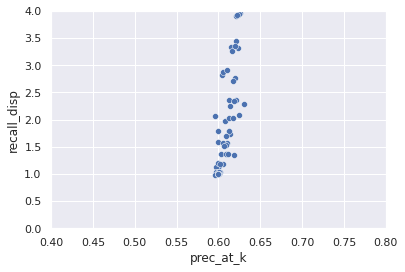

In [157]:
ax = sns.scatterplot('prec_at_k', 'recall_disp', data=res_df)
ax.set_xlim((0.4,0.8))
ax.set_ylim((0,4))

(0.0, 4.0)

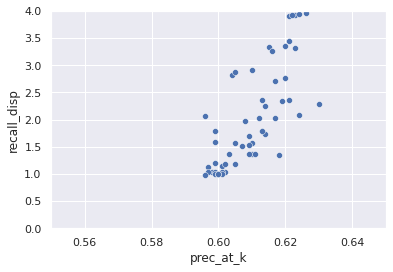

In [158]:
ax = sns.scatterplot('prec_at_k', 'recall_disp', data=res_df)
ax.set_xlim((0.55,0.65))
ax.set_ylim((0,4))

In [159]:
bias_res_list = []
for grain in [0.000, 0.001, 0.005, 0.01, 0.025, 0.05, 0.1, 0.5, 1.0]:
  bias_res_list.append(prec_at_k_trials_bias_v2(split1_combined, k=1000, grain=grain, n_trial=5))

bias_results = pd.concat(bias_res_list)

In [162]:
bias_results['grain_cat'] = pd.Categorical(bias_results['grain'])

(0.0, 8.0)

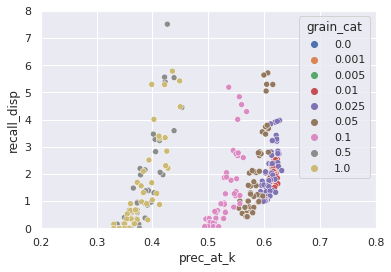

In [164]:
ax = sns.scatterplot('prec_at_k', 'recall_disp', hue='grain_cat', data=bias_results)
ax.set_xlim((0.2,0.8))
ax.set_ylim((0,8))

(0.0, 3.0)

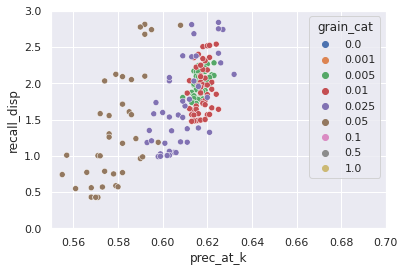

In [167]:
ax = sns.scatterplot('prec_at_k', 'recall_disp', hue='grain_cat', data=bias_results.loc[bias_results['grain'] <= 0.05])
ax.set_xlim((0.55,0.7))
ax.set_ylim((0,3))

(0.0, 5.0)

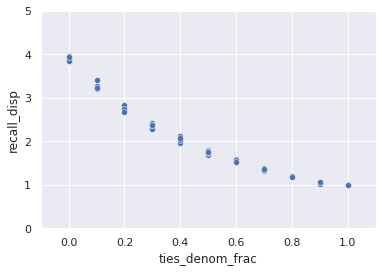

In [172]:
ax = sns.scatterplot('ties_denom_frac', 'recall_disp', data=bias_results.loc[bias_results['grain'] == 0.025])
ax.set_xlim((-0.1,1.1))
ax.set_ylim((0,5))

(0.4, 0.8)

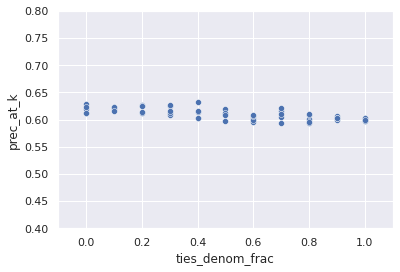

In [174]:
ax = sns.scatterplot('ties_denom_frac', 'prec_at_k', data=bias_results.loc[bias_results['grain'] == 0.025])
ax.set_xlim((-0.1,1.1))
ax.set_ylim((0.4,0.8))

This seems much cleaner than above -- a clear relationship between granularity and eventual drop-off in precision and much more predictable behavior with regards to disparities as well.

However, this approach is definitely less clear-cut than the recall adjuster -- at what granularity do we consider the scores equivalent given the error bars? A grain of 0.05 seems too large (the precision has clearly dropped off), while 0.01 seems tightly distributed around the un-smoothed value, but 0.025 is a bit of a harder call: still distributed around the "true" value but with wider error bars. In this particular case, it appears that the attainable disparity improvement is pretty sensitive to that decision (again, making this a bit less clear-cut than the recall adjuster approach). 

The main advantage this approach would seem to have over the direct recall adjuster, however, is that it acknowledges the actual precision of the model scores isn't nearly as high as the output and only accounts for a protected attribute in choosing between equivalently-qualified (or equivalently-at need) individuals in a manner that doesn't require separate thresholds for different types of individuals. As such, the protected attribute is used only as a tie breaker, which might be more robust to challenges in some cases?

Additionally, what I've looked at so far doesn't consider the temporal aspect of the data yet, just within a given split. In reality, we would need to learn both a granularity and fraction of each bias group to chose among the ties from historical results. For the first, this would be based on something like the largest granularity where the precision at k is statistically the same as the value with grain=0.0. For the second, it might be the fraction that yields the lowest disparity among these equivalent sets or perhaps some concept of pareto optimality (though this probably makes less sense if the scores in the band are indeed equivalent up to the granularity).

In [29]:
# looking at the next time forward with grain=0.025 and denom_frac=0.9

split2_preds = pd.read_csv(DATAPATH + 'predictions_c598fbe93f4c218ac7d325fb478598f1.csv.gz', compression='gzip')
split2_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

split2_combined = pd.merge(split2_preds, split2_attrdf, how='left', on=[entity_col, date_col], sort=True, copy=True)

In [30]:
res_df = prec_at_k_trials_bias_v2(split2_combined, k=1000, grain=0.025, n_trial=5)

In [31]:
res_df.loc[res_df['ties_denom_frac']==0.9]

,k,grain,bias_attr,bias_denom,ties_denom_frac,score_thresh,num_above_high,num_selected,needed_at_thresh,num_at_thresh,prec_at_k,recall_disp
45,1000,0.025,poverty_level,highest,0.9,0.527625,522,1000,478,1234,0.581,0.992164
46,1000,0.025,poverty_level,highest,0.9,0.527625,522,1000,478,1234,0.572,0.959928
47,1000,0.025,poverty_level,highest,0.9,0.527625,522,1000,478,1234,0.573,0.963510
48,1000,0.025,poverty_level,highest,0.9,0.527625,522,1000,478,1234,0.583,0.999328
49,1000,0.025,poverty_level,highest,0.9,0.527625,522,1000,478,1234,0.572,0.959928


In [180]:
prec_at_k_trials_v2(split2_combined, k=1000, grain=0.00, n_trial=5)

,k,grain,score_thresh,num_above_high,num_at_thresh,prec_at_k
0,1000,0.0,0.527625,999,1,0.552
1,1000,0.0,0.527625,999,1,0.552
2,1000,0.0,0.527625,999,1,0.552
3,1000,0.0,0.527625,999,1,0.552
4,1000,0.0,0.527625,999,1,0.552


Here we find very much the same result rolling forward into the next validation set as we do with the post-hoc thresholds/recall adjuster, even including the roughly 3pp increase in precision at k with the fairness-improved top k sets (interestingly, this actually shows some robustness to different draws from the tied scores there, suggesting this increase is more due to the non-stationary nature of the data across splits than luck of the draw in making the post-hoc adjustments).

As a proof of concept, this seems promising, but ideally we could find a more automated means of choosing the grain and denom_frac parameters here than reading sensible values off plots.

Likewise, extensions to cases with more than two values on the protected attribute again seems more messy than recall adjuster approach (which yields a unique solution), though it might be simpler here if we chose the fractions based on what would be needed to (in expectation) yield equal recalls when learning the parameters in historical data (that is, based on how many more TPs are needed for each group and the relative pools available).

In [32]:
results.head(5)

,k,grain,score_thresh,num_above_high,num_at_thresh,prec_at_k
0,1000,0.0,0.448564,999,1,0.616
1,1000,0.0,0.448564,999,1,0.616
2,1000,0.0,0.448564,999,1,0.616
3,1000,0.0,0.448564,999,1,0.616
4,1000,0.0,0.448564,999,1,0.616


In [33]:
results.groupby('grain')['prec_at_k'].mean()

grain
0.000    0.616000
0.001    0.617400
0.005    0.615933
0.010    0.616900
0.025    0.610567
0.050    0.591333
0.100    0.538300
0.200    0.456967
0.300    0.405000
0.400    0.388267
0.500    0.392633
1.000    0.381300
Name: prec_at_k, dtype: float64

In [39]:
# Note that we want standard deviation here, not SEM, because we'll realize a single draw from this distribution in an actual application (rather than the mean of the distribution)
results.groupby('grain')['prec_at_k'].std()

grain
0.000    0.000000
0.001    0.001453
0.005    0.002716
0.010    0.004490
0.025    0.006781
0.050    0.012254
0.100    0.012540
0.200    0.011577
0.300    0.019129
0.400    0.014960
0.500    0.017319
1.000    0.016626
Name: prec_at_k, dtype: float64

In [40]:
(results.groupby('grain')['prec_at_k'].mean() - 0.616)/results.groupby('grain')['prec_at_k'].std()

grain
0.000          NaN
0.001     0.963721
0.005    -0.024549
0.010     0.200436
0.025    -0.801292
0.050    -2.012945
0.100    -6.196170
0.200   -13.736679
0.300   -11.030186
0.400   -15.223262
0.500   -12.896846
1.000   -14.116437
Name: prec_at_k, dtype: float64

In [44]:
import math

In [173]:
# Only care about _decreases_ in prec@k, so basically a one-tailed test with critical values:
# 1.96 for 2.5%, 1.65 for 5%, or 1.28 for 10%
# (so depends on how conservative you want to be...)

# Another possible direction here might be to compare actual label distributions for examples just above and just below the top k threshold,
# though would need to explore the right way to think about this comparison

# TODO: Given that we know the labels these trials are being drawn from, it seems like we could actually calculate things here analytically
# rather than needing to do the repeated draws, but would need to explore that direction a bit...
def find_grain_and_frac(
    df, k, n_trial=30, t_crit=-1.65, min_step=0.0001, start_step=0.04,
    score_col='predict_proba', label_col='quickstart_label',
    seln_col='tmp_selection', rand_col='tmp_random',
    bias_attr='poverty_level', bias_denom='highest'
):

  all_grain_results = []

  # calculate values at a grain of 0 to compare against (still do the draws because there may be ties)
  grain0_df = prec_at_k_trials_v2(
      df, k, grain=0.0, n_trial=n_trial,
      score_col=score_col, label_col=label_col,
      seln_col=seln_col, rand_col=rand_col
  )
  grain0_mean = grain0_df['prec_at_k'].mean()
  grain0_std = grain0_df['prec_at_k'].std()
  all_grain_results.append(grain0_df)

  # initialize parameters for search
  tried_grains = [0.0]
  curr_grain = 0.0
  best_grain = 0.0
  step_size = start_step
  step_dir = 1 # 1 for positive, -1 for negative

  while step_size > min_step:
    curr_grain = curr_grain + step_dir * step_size

    grain_res = prec_at_k_trials_v2(
      df, k, grain=curr_grain, n_trial=n_trial,
      score_col=score_col, label_col=label_col,
      seln_col=seln_col, rand_col=rand_col
    )
    grain_mean = grain_res['prec_at_k'].mean()
    grain_std = grain_res['prec_at_k'].std()
    grain_t_value = (grain_mean - grain0_mean)/math.sqrt(grain_std**2 + grain0_std**2)
    all_grain_results.append(grain_res)

    print(f'tried grain of {curr_grain} found t-value of {grain_t_value}.')

    if grain_t_value < t_crit:
      # significant loss in precision@k, so step towards smaller grain
      step_dir = -1
    else:
      # precision still similar to initial, so step towards larger grain
      # and update the best grain to the current one
      step_dir = 1
      best_grain = curr_grain
    
    # update step size:
    # if we've already tried a grain in the direction we're stepping, step halfway between
    # otherwise, continue with the current step size

    if step_dir == 1 and curr_grain < max(tried_grains):
      closest_tried = min([g for g in tried_grains if g > curr_grain])
      step_size = (closest_tried - curr_grain)/2
    elif step_dir == -1 and curr_grain > min(tried_grains):
      # since we start with 0, this should always apply when stepping to smaller grains
      closest_tried = max([g for g in tried_grains if g < curr_grain])
      step_size = (curr_grain - closest_tried)/2

    tried_grains.append(curr_grain)

  # to calculate the desired frac after finding the best grain, we can look at the current
  # level of recall for each group and available labels among the tied scores near the
  # top k cut-off:

  tmp_df = df.copy()
  tmp_df[rand_col] = np.random.random(tmp_df.shape[0])
  tmp_df.sort_values([score_col, rand_col], ascending=[False, False], inplace=True)

  score_thresh = tmp_df.head(k)[score_col].min()

  score_high = score_thresh + best_grain
  score_low = score_thresh - best_grain

  bias_denom_pos = tmp_df.loc[tmp_df[bias_attr] == bias_denom][label_col].sum()
  bias_num_pos = tmp_df.loc[tmp_df[bias_attr] != bias_denom][label_col].sum()

  # give examples above thresh+grain a score of "1" and those with ties a score of 0.5 for tracking
  tmp_df[seln_col] = 0.0
  tmp_df.loc[tmp_df[score_col] > score_high, seln_col] = 1.0
  tmp_df.loc[(tmp_df[score_col] <= score_high) & (tmp_df[score_col] >= score_low), seln_col] = 0.5

  # number of examples we need to fill out the top k from the "0.5" ties
  needed = k - tmp_df.loc[tmp_df[seln_col] == 1.0].shape[0]

  # number of each attribute group with tied scores available to fill out the top k
  avail_denom = tmp_df.loc[(tmp_df[seln_col] == 0.5) & (tmp_df[bias_attr] == bias_denom)].shape[0]
  avail_num = tmp_df.loc[(tmp_df[seln_col] == 0.5) & (tmp_df[bias_attr] != bias_denom)].shape[0]

  # number of examples from each attribute group above the "high" threshold
  curr_denom_ex = tmp_df.loc[(tmp_df[seln_col] == 1.0) & (tmp_df[bias_attr] == bias_denom)].shape[0]
  curr_num_ex = tmp_df.loc[(tmp_df[seln_col] == 1.0) & (tmp_df[bias_attr] != bias_denom)].shape[0]

  # number of true positives (label 1's) above the "high" threshold for each group
  curr_denom_tp = tmp_df.loc[(tmp_df[seln_col] == 1.0) & (tmp_df[bias_attr] == bias_denom)][label_col].sum()
  curr_num_tp = tmp_df.loc[(tmp_df[seln_col] == 1.0) & (tmp_df[bias_attr] != bias_denom)][label_col].sum()

  # we'll select examples with tied scores from each group randomly, so in expectation, we would get label 1's
  # at a rate given by the overall label 1 mean in this group
  avail_denom_label_frac = tmp_df.loc[(tmp_df[seln_col] == 0.5) & (tmp_df[bias_attr] == bias_denom)][label_col].mean()
  avail_num_label_frac = tmp_df.loc[(tmp_df[seln_col] == 0.5) & (tmp_df[bias_attr] != bias_denom)][label_col].mean()

  # given all of these values, can find the fraction of examples from the denominator group that would
  # get us as close as possible to equalized recall across the groups (can do this without regard for
  # the number actually available, since may be more or fewer available at deployment...)
  best_recall_diff = None
  best_denom_n = None
  for denom_n in range(needed+1):
    exp_recall_denom = (curr_denom_tp + denom_n*avail_denom_label_frac) / bias_denom_pos
    exp_recall_num = (curr_num_tp + (needed-denom_n)*avail_num_label_frac) / bias_num_pos
    recall_diff = abs(exp_recall_denom - exp_recall_num)
    # if denom_n % 10 == 0:
    #   print(f'Tried denom_n={denom_n} and found recall_diff of {recall_diff}')
    if best_recall_diff is None or recall_diff < best_recall_diff:
      best_recall_diff = recall_diff
      best_denom_n = denom_n

  # analytically, this should be:
  math_denom_frac = (bias_denom_pos * curr_num_tp - bias_num_pos * curr_denom_tp + avail_num_label_frac * needed * bias_denom_pos) / (avail_denom_label_frac * needed * bias_num_pos + avail_num_label_frac * needed * bias_denom_pos)

  del(tmp_df)

  return {
      'best_grain': best_grain, 
      'results_df': pd.concat(all_grain_results),
      'best_denom_frac': best_denom_n/needed,
      'math_denom_frac': math_denom_frac
      }


In [109]:
res_dict = find_grain_and_frac(
    split1_combined, k=1000, n_trial=30, t_crit=-1.28, min_step=0.0001, start_step=0.08,
    score_col='predict_proba', label_col='quickstart_label',
    seln_col='tmp_selection', rand_col='tmp_random',
    bias_attr='poverty_level', bias_denom='highest'
)

tried grain of 0.08 found t-value of -4.35702311883572.
tried grain of 0.04 found t-value of -1.741756982109241.
tried grain of 0.02 found t-value of -1.0574262177544913.
tried grain of 0.03 found t-value of -0.5198318918105247.
tried grain of 0.035 found t-value of -1.1525945792511862.
tried grain of 0.037500000000000006 found t-value of -1.2064549029637652.
tried grain of 0.03875000000000001 found t-value of -1.2137443535703019.
tried grain of 0.03937500000000001 found t-value of -1.5079993099558204.
tried grain of 0.03906250000000001 found t-value of -1.237860209575641.
tried grain of 0.03921875000000001 found t-value of -1.6583269850444433.


In [110]:
res_dict['best_grain']

0.03906250000000001

(0.35, 0.65)

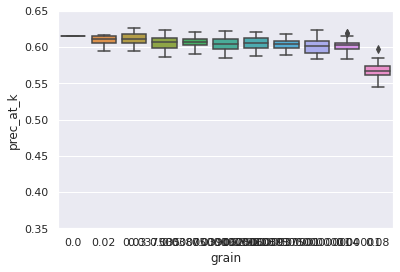

In [111]:
ax = sns.boxplot('grain', 'prec_at_k', data=res_dict['results_df'].sort_values('grain'))
ax.set_ylim((0.35,0.65))

In [112]:
res_dict['results_df'].groupby('grain')['prec_at_k'].mean()

grain
0.000000    0.616000
0.020000    0.609267
0.030000    0.611867
0.035000    0.605433
0.037500    0.606833
0.038750    0.604033
0.039063    0.604933
0.039219    0.603967
0.039375    0.601067
0.040000    0.601867
0.080000    0.567067
Name: prec_at_k, dtype: float64

This seems reasonable but does appear to be a bit sensitive to run-to-run variation (and seems like it can get a little trapped going one direction or another, so might be best to add some stochastic component to the search steps?)

In [193]:
res_dict = find_grain_and_frac(
    split1_combined, k=1000, n_trial=30, t_crit=-1.28, min_step=0.0001, start_step=0.08,
    score_col='predict_proba', label_col='quickstart_label',
    seln_col='tmp_selection', rand_col='tmp_random',
    bias_attr='poverty_level', bias_denom='highest'
)

tried grain of 0.08 found t-value of -3.5043112643462133.
tried grain of 0.04 found t-value of -1.390989344485999.
tried grain of 0.02 found t-value of -1.1206148709187949.
tried grain of 0.03 found t-value of -1.5034209842502801.
tried grain of 0.025 found t-value of -0.7951372791612443.
tried grain of 0.0275 found t-value of -0.757657859363898.
tried grain of 0.028749999999999998 found t-value of -0.6814185279187952.
tried grain of 0.029375 found t-value of -1.6615556762797852.
tried grain of 0.029062499999999998 found t-value of -0.8275750216066174.
tried grain of 0.029218749999999998 found t-value of -1.1210767975888567.


In [194]:
res_dict['best_denom_frac']

0.8495145631067961

In [195]:
res_dict['best_grain']

0.029218749999999998

In [196]:
res_dict['math_denom_frac']

0.8500030402237883

In [197]:
res_df2 = prec_at_k_trials_bias_v2(split2_combined, k=1000, grain=res_dict['best_grain'], n_trial=5)

In [198]:
res_df2.loc[(res_df2['ties_denom_frac'] > 0.7) & (res_df2['ties_denom_frac'] < 0.9)]

,k,grain,bias_attr,bias_denom,ties_denom_frac,score_thresh,num_above_high,num_selected,needed_at_thresh,num_at_thresh,prec_at_k,recall_disp
35,1000,0.029219,poverty_level,highest,0.7,0.527625,475,1000,525,1468,0.571,1.100376
36,1000,0.029219,poverty_level,highest,0.7,0.527625,475,1000,525,1468,0.566,1.073591
37,1000,0.029219,poverty_level,highest,0.7,0.527625,475,1000,525,1468,0.561,1.124380
38,1000,0.029219,poverty_level,highest,0.7,0.527625,475,1000,525,1468,0.562,1.104484
39,1000,0.029219,poverty_level,highest,0.7,0.527625,475,1000,525,1468,0.569,1.047571
40,1000,0.029219,poverty_level,highest,0.8,0.527625,475,1000,525,1468,0.583,0.920029
41,1000,0.029219,poverty_level,highest,0.8,0.527625,475,1000,525,1468,0.572,0.913813
42,1000,0.029219,poverty_level,highest,0.8,0.527625,475,1000,525,1468,0.586,0.923997
43,1000,0.029219,poverty_level,highest,0.8,0.527625,475,1000,525,1468,0.583,0.901137
44,1000,0.029219,poverty_level,highest,0.8,0.527625,475,1000,525,1468,0.569,0.890580


In [199]:
res_df2.groupby('ties_denom_frac')['prec_at_k', 'recall_disp'].mean()

,prec_at_k,recall_disp
ties_denom_frac,,
0.0,0.5274,7.612215
0.1,0.5278,4.836741
0.2,0.5426,3.493745
0.3,0.5400,2.605006
0.4,0.5542,2.052677
0.5,0.5490,1.640851
0.6,0.5636,1.300639
0.7,0.5658,1.090080
0.8,0.5786,0.909911


(0.35, 0.65)

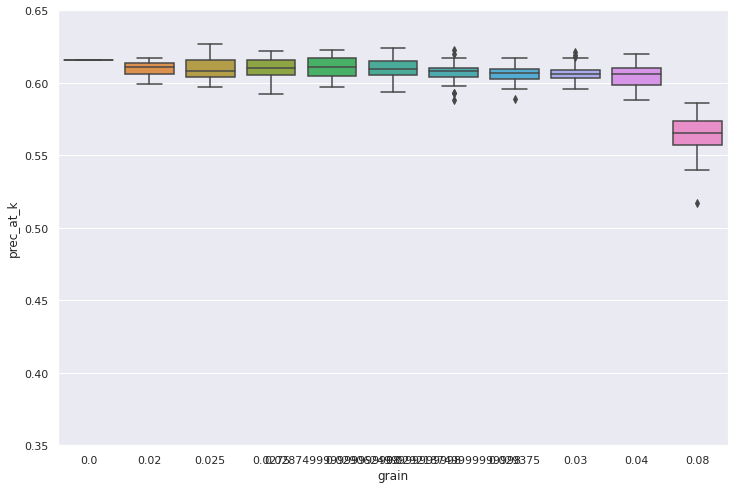

In [200]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot('grain', 'prec_at_k', data=res_dict['results_df'].sort_values('grain'), ax=ax)
ax.set_ylim((0.35,0.65))

This seems to work reasonably well and certainly improves the fairness characteristics of the result, but not as well (or consistently) as choosing the grain by hand from simple grid I ran above.

I think the limitation we're running into here is that the assumption that the t-values will be relatively stable across runs and relatively smooth locally across grains, which seems true over the relatively large scale but less so at smaller scales. Unfortunately, those smaller scales are still large enough have to an impact on the results -- a grain of 0.02 vs 0.04 does yield different recall disparity and precision@k values. And, that said, it's not entirely clear where on the threshold really should be even by looking at the graphs...

In [201]:
res_dict2 = find_grain_and_frac(
    split1_combined, k=1000, n_trial=100, t_crit=-1.28, min_step=0.0001, start_step=0.08,
    score_col='predict_proba', label_col='quickstart_label',
    seln_col='tmp_selection', rand_col='tmp_random',
    bias_attr='poverty_level', bias_denom='highest'
)

tried grain of 0.08 found t-value of -3.9964809214387618.
tried grain of 0.04 found t-value of -1.5968356197515867.
tried grain of 0.02 found t-value of -1.0934835430998038.
tried grain of 0.03 found t-value of -1.0493455782515042.
tried grain of 0.035 found t-value of -1.0620179254011148.
tried grain of 0.037500000000000006 found t-value of -1.2481568206928775.
tried grain of 0.03875000000000001 found t-value of -1.560719127273059.
tried grain of 0.038125000000000006 found t-value of -0.9556471241832875.
tried grain of 0.038437500000000006 found t-value of -1.349176040345378.
tried grain of 0.03828125 found t-value of -1.2240794407090105.


(0.35, 0.65)

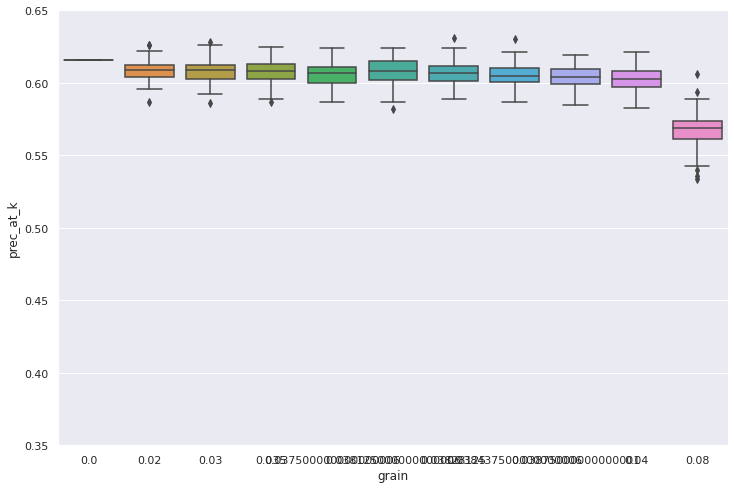

In [202]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot('grain', 'prec_at_k', data=res_dict2['results_df'].sort_values('grain'), ax=ax)
ax.set_ylim((0.35,0.65))

In [203]:
# Looking at the broader range with more sampling in this region

res_list3 = []
for grain in [0.000, 0.001, 0.005, 0.01, 0.02, 0.0225, 0.025, 0.0275, 0.03, 0.0325, 0.035, 0.0375, 0.04, 0.05, 0.1, 0.2, 0.5, 1.0]:
  res_list3.append(prec_at_k_trials_v2(split1_preds, k=1000, grain=grain, n_trial=30))

results3 = pd.concat(res_list3)

(0.35, 0.65)

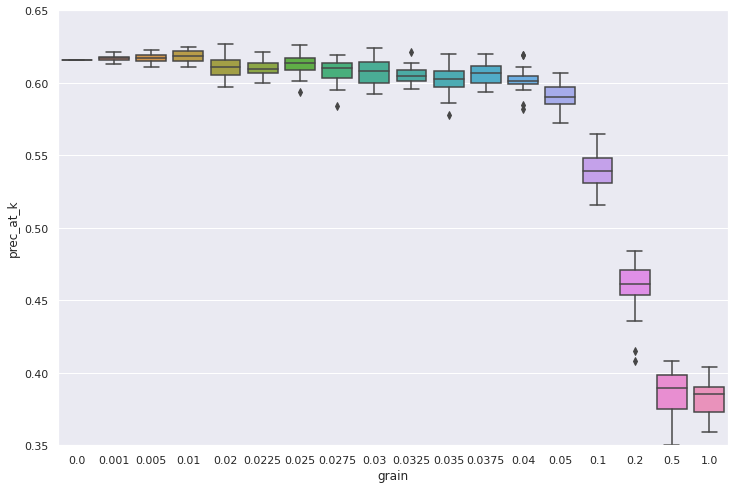

In [206]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot('grain', 'prec_at_k', data=results3.sort_values('grain'), ax=ax)
ax.set_ylim((0.35,0.65))

### Combine predictions with protected attributes

In [13]:
df = pd.merge(split1_preds, split1_attrdf, how='left', on=[entity_col,date_col], left_index=True, right_index=False, sort=True, copy=True)

MergeError: ignored

### Sort by score, then split by protected attribute (poverty level)

In [ ]:
protected_attribute_groups = df[protected_attribute_col].unique()

In [ ]:
df = df.sort_values('predict_proba', ascending=False)
subgroup_dfs = []
for grp in protected_attribute_groups:
    subgroup_dfs.append(df[df[protected_attribute_col]==grp].copy())

### Calculate within-subgroup cumulative recall

Here, we calculate the recall up to and including each row within the highest-poverty and lower-poverty subsets of the test set. Doing this allows us to recombine and sort the sets in a way that will let find recall-equalizing "top k" list sizes for each subgroup.

In [ ]:
for subgrp_df in subgroup_dfs:
    subgrp_df['cumsum_recall'] = subgrp_df[label_col].cumsum() / subgrp_df[label_col].sum()

### Recombine the subgroup sets and sort by this cumulative recall

In [ ]:
recall_df = pd.concat(subgroup_dfs, axis=0).sort_values('cumsum_recall', ascending=True)

### Find subgroup sizes, holding the overall list size (1000) constant

Now we can simply threshold this re-sorted list by `top_k` (here, 1000) to identify how many individuals from each group we should apply in the future.

Notice here that each subgroup will still be ordered by their predicted score, but the scores will no longer be perfectly ordered across subgroups.

In [ ]:
new_pp = recall_df.head(top_k).copy()
new_pp.tail()

In [ ]:
new_pp[protected_attribute_col].value_counts()

Let's just store this to re-use below:

In [ ]:
subgroup_k = {} 
for grp in protected_attribute_groups:
  subgroup_k[grp] = new_pp[protected_attribute_col].value_counts()[grp]

### Apply these subgroup-specific sizes to future test set data

Now we have calculated the number of projects we need to select from each poverty level, we can apply these to the most recent split to assess how well this method reduces the recall disparities we saw initially and whether this has any impact on the overall precision of the model.

### Load the predictions and protected attributes from the future test set

Note that the predictions here correspond to the same model + hyperparameters we specified above

In [ ]:
split2_preds = pd.read_csv(DATAPATH + 'predictions_c598fbe93f4c218ac7d325fb478598f1.csv.gz', compression='gzip')
split2_attrdf = pd.read_csv(DATAPATH + 'test_20121201_20130201_protected.csv.gz', compression='gzip')

df2 = pd.merge(split2_preds, split2_attrdf, how='left', on=[entity_col, date_col], left_index=True, right_index=False, sort=True, copy=True)

Take a quick look to make sure the data loaded without any issue:

In [ ]:
df2.head()

### Split the test set by poverty level to apply the thresholds

In [ ]:
df2 = df2.sort_values('predict_proba', ascending=False)
new_subgroup_dfs = {}
for grp in protected_attribute_groups:
    new_subgroup_dfs[grp] = df2[df2[protected_attribute_col]==grp].copy()

### Choose the number of projects from each subgroup found above

Notice here that we're choosing the "top k" individuals within each subgroup based on their predicted score -- in a deployment, we wouldn't know the true labels to calculate recall values, which is why we had to go one step back in time to find these group sizes.

In [ ]:
pp_dfs = []
for grp in protected_attribute_groups:
    pp_dfs.append(new_subgroup_dfs[grp].head(subgroup_k[grp]))

### Recombine and create a predicted class label for this resulting set
That is, 1,000 projects with a label 1 chosen by this process and 0 otherwise

In [ ]:
new_pp2 = pd.concat(pp_dfs, axis=0).sort_values('predict_proba', ascending=True)

mitigated_df = df2.copy()
mitigated_df = mitigated_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
mitigated_df['score'] = mitigated_df.apply(lambda x: 1.0 if x.name in new_pp2.index.tolist() else 0, axis=1)

for comparison, let's also look at the unmitigated result again...

In [ ]:
unadjusted_df = df2.sort_values('predict_proba', ascending=False).copy()
unadjusted_df = unadjusted_df.rename(columns = {label_col:'label_value'}) # naming for Aequitas

# create a "score" column with the predicted class (named "score" for use with Aequitas below)
unadjusted_df['score'] = unadjusted_df.apply(lambda x: 1.0 if x.name in unadjusted_df.head(top_k).index.tolist() else 0, axis=1)

### Running Aequitas - Before and After

#### For the original score, without post-hoc adjustment for equity

In [ ]:
bdf_unadjusted = aequitas_audit(unadjusted_df, protected_attribute_ref_group)
ap.disparity(bdf_unadjusted, metrics, protected_attribute_col, fairness_threshold=disparity_threshold)

#### For the score, with post-hoc disparity mitigation

In [ ]:
bdf_mitigated = aequitas_audit(mitigated_df, protected_attribute_ref_group)

ap.disparity(bdf_mitigated, metrics, protected_attribute_col, fairness_threshold=disparity_threshold)

So, it looks the post-hoc adjustments have actually manage to mitigate the existing disparity pretty well (perhaps even over-shooting somewhat, though still within our fairness threshold of 1.3).

However, the natural question here is where there is a fairness-accuracy trade-off here: What cost did we incur in terms of model performance, that is overall precision?

#### Before: Precision of the original, unadjusted score

In [ ]:
unadjusted_df.loc[unadjusted_df['score']==1]['label_value'].mean()

#### After: Precision of the new, disparity-mitigated score

In [ ]:
mitigated_df.loc[mitigated_df['score']==1]['label_value'].mean()

Somewhat surprisingly, we actually don't seem to see any trade-off with the disparity mitigation here!

### Adding to the model selection (tradeoff) graph

Finally, let's look at how this new option stacks up against what we plotted in our model selection process:

In [ ]:
mitigated_precision_5 = mitigated_df.loc[mitigated_df['score']==1]['label_value'].mean()
plot_configs = {
    'evals_df':evals_df, 
    'aequitas_df':aequitas_df,
    'attr_col':'poverty_level', 
    'group_name':'highest',
    'performance_col':'model_precision',
    'bias_metric':'tpr', 
    'flip_disparity':True, 
    'mitigated_tags':['Equalizing Recall'],
    'mitigated_bdfs':[bdf_mitigated], 
    'mitigated_performances':[mitigated_precision_5], 
    'ylim':None
}
create_scatter_disparity_performance(**plot_configs)